In [10]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [11]:
import os
import gc
import sys
srcpath = os.path.realpath('./../SourceFiles')
sys.path.append(srcpath)
#from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst
from pulse_sequencev2 import EPR_pulse

# Connect to the instrument

In [12]:
# Connect to instrument

# Please choose appropriate address:
inst_addr = '169.254.18.140' #Proteus Lan

inst = TEVisaInst(inst_addr)

resp = inst.send_scpi_query("*IDN?")
print('connected to: ' + resp)


connected to: Tabor Electronics,P2582D,000002248484,1.237.0 --slot#: 5, 


In [13]:
# The paranoia-level is either 
# low (0), normal (1) or debug (2)
paranoia_level = 2

print ('Reset instrument ..')

# Reset the instrument
inst.send_scpi_cmd('*CLS; *RST')

dac_mode = 16 

# Get the model:
model_name = inst.send_scpi_query('SYST:INF:MODel?')
print('Model: {0} '.format(model_name))

# Get model dependant parameters:

# scaling
max_dac = 2 ** dac_mode - 1
half_dac = max_dac / 2.0
wpt_type = np.uint16   

    
# Get the available memory in bytes of wavform-data (per DDR):
resp = inst.send_scpi_query(":TRACe:FREE?")
arbmem_capacity = int(resp)
print("Available memory per DDR: {0:,} wave-bytes".format(arbmem_capacity))

sampleRateDAC = 2.5E9
cmd = ':FREQ:RAST {0}'.format(sampleRateDAC) 
inst.send_scpi_cmd(cmd)

print('Done')

Reset instrument ..
Model: P2582D 
Available memory per DDR: 4,286,532,544 wave-bytes
Done


# Create a pulse sequence from the written code "EPR_pulse.py" 


In [18]:
# Define the pulse sequence
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
p = EPR_pulse(sampling_rate=2.5e9,Vpp=1)  

steps = [
    ('Gaussian', 20e-6, {'amplitude': 0.5 ,'phase': 'x','f_c':.5e6}),
    ('delay', 10e-6),
    ('gaussian', 20e-6, {'amplitude': 1, 'phase': '-x','f_c':.5e6}),
    ('delay', 10e-6),
    ('detection', 5e-6, {'amplitude': 0.5, 'phase': 'x','f_c':.5e6}),
]

t_seq, y_seq, y_det = p.pulse_sequence(steps)
y_seq = p.DAC_output(y_seq)
y_det = p.DAC_output(y_det)
dig_t, dig_y = p.dig_output(steps) 


C:\Users\User\Documents\Tabor Electronics\python\AWT_cryogenic-magnet\SourceFiles\pulse_sequencev2.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  return y_dac.astype(np.uint16)


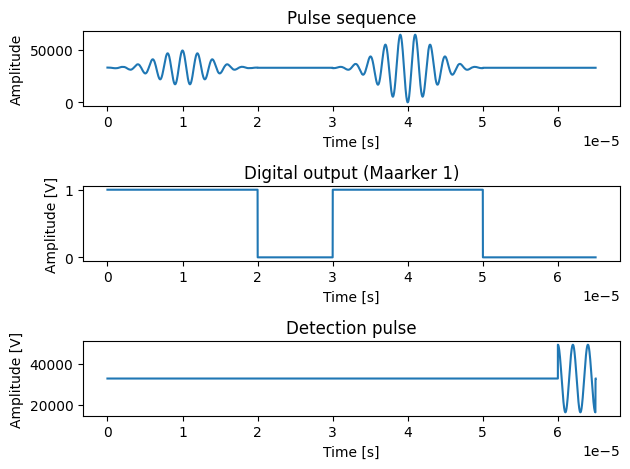

In [19]:
%matplotlib inline
plt.figure()
plt.subplot(311)
plt.plot(t_seq, y_seq)
plt.title('Pulse sequence')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.subplot(312)
plt.plot(dig_t, dig_y)
plt.title('Digital output (Maarker 1)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [V]')
plt.subplot(313)
plt.plot(t_seq, y_det)      
plt.title('Detection pulse')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [V]')

plt.tight_layout()
plt.show()
plt.close()


In [20]:
# Download waveform to the AWT
# Download segments


wav = y_seq
seglen = len(wav)

# Select channel 1 for the waveform
cmd = ':INST:CHAN {0}'.format(1)
inst.send_scpi_cmd(cmd)

# Define segment
cmd = ':TRAC:DEF {0}, {1}'.format(1, seglen)
inst.send_scpi_cmd(cmd)

# Select the segment
cmd = ':TRAC:SEL {0}'.format(1)
inst.send_scpi_cmd(cmd)
    
# Send the binary-data:
inst.write_binary_data(':TRAC:DATA', wav)
    
resp = inst.send_scpi_query(':SYST:ERR?')
resp = resp.rstrip()
if not resp.startswith('0'):
    print('ERROR: "{0}" after writing binary values'.format(resp))

# Play the specified segment at the selected channel:
cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(segnum)
inst.send_scpi_cmd(cmd)
# Turn on the output of the selected channel:
inst.send_scpi_cmd(':OUTP ON')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Channel 2: Detection pulse
det = y_det
seglen = len(det)

# Select channel 2 for the waveform     
cmd = ':INST:CHAN {0}'.format(2)
inst.send_scpi_cmd(cmd)

# Define segment    
cmd = ':TRAC:DEF {0}, {1}'.format(2, seglen)
inst.send_scpi_cmd(cmd)

# Select the segment
cmd = ':TRAC:SEL {0}'.format(2)
inst.send_scpi_cmd(cmd)

# Send the binary-data: 
inst.write_binary_data(':TRAC:DATA', det)
resp = inst.send_scpi_query(':SYST:ERR?')
resp = resp.rstrip()
if not resp.startswith('0'):
    print('ERROR: "{0}" after writing binary values'.format(resp))
# Play the specified segment at the selected channel:
cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(2)
inst.send_scpi_cmd(cmd)
# Turn on the output of the selected channel:
inst.send_scpi_cmd(':OUTP ON')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)







print()

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)



0, no error
0, no error

0, no error


# Applying to pulse sequences

In [ ]:
# Define the pulse sequence
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)
from pulse_sequence import EPR_pulse
p = EPR_pulse(sampling_rate=2.5e9,Vpp=1)  

steps = [
    ('Gaussian', 20e-6, {'amplitude': 0.5 ,'phase': 'x','f_c':.5e6}),
    ('delay', 10e-6),
    ('gaussian', 20e-6, {'amplitude': 1, 'phase': '-x','f_c':.5e6}),
    ('delay', 10e-6),
]

t_seq, y_seq = p.pulse_sequence(steps)
y_seq = p.DAC_output(y_seq)
dig_t, dig_y = p.dig_output(steps) 





# Generate the phase cycled segments

In [ ]:
def generate_phasecycled_sequences(pulse_gen, base_sequence, phase_list):
    """
    Generate a list of (t, y) sequences for each set of phase values.

    Parameters:
        pulse_gen : EPR_pulse
            An instance of your EPR_pulse class.
        base_sequence : list of tuples
            Base sequence with phase placeholders in each pulse step.
        phase_list : list of lists
            Each sublist corresponds to [phase1, phase2, ...] for one full cycle.

    Returns:
        List of (t, y) pairs, one for each phase cycle.
    """
    all_sequences = []

    for phase_set in phase_list:
        steps = []
        pulse_idx = 0
        for pulse_type, duration, params in base_sequence:
            params_copy = params.copy()
            if pulse_type.lower() != 'delay':
                params_copy['phase'] = phase_set[pulse_idx]
                pulse_idx += 1
            steps.append((pulse_type, duration, params_copy))

        t_seq, y_seq = pulse_gen.pulse_sequence(steps)
        all_sequences.append((t_seq, y_seq))

    return all_sequences



pulse = EPR_pulse(sampling_rate=2.5e9, Vpp=1)

# Base sequence (2 pulses + 2 delays), no phase filled in yet
base_seq = [
    ('Gaussian', 20e-6, {'amplitude': 1, 'f_c': 0e6}),  # P1
    ('delay',    10e-6,{}),                                 # dt
    ('Square',   20e-6, {'amplitude': 1, 'f_c': 0.05e6}),  # P2
    ('delay',    10e-6,{}),
    ('Square',   20e-6, {'amplitude': 1, 'f_c': .05e6}),  # P2

]

phase_cycle = [
    [0, 0, 90],
    [90, 90,100],
    [180, 0,200],
    [270, 0,160],
    [0,0,0]
]

sequences = generate_phasecycled_sequences(pulse, base_seq, phase_cycle)

# Optional: Convert to DAC or dig_output
for i, (t, y) in enumerate(sequences):
    y_dac = pulse.DAC_output(np.real(y))  # optional: real part only
    # OR: t, dig = pulse.dig_output(...) if you want binary output
    print(f"Cycle {i}: {len(t)} samples, duration {t[-1]*1e9:.1f} ns")

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

for i, (t, y) in enumerate(sequences):
    axs[i].plot(t * 1e9, np.real(y), label='Real', color='blue')
    axs[i].plot(t * 1e9, np.imag(y), label='Imag', color='orange', linestyle='--')
    axs[i].set_ylabel(f'Cycle {i}\nAmplitude (mV)')
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

axs[-1].set_xlabel('Time (ns)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
seg = [(t,pulse.DAC_output(np.real(y))) for t,y in sequences]
plt.plot(seg[0][0], seg[0][1])

# Generate segments for measuring T2 with Phase cycling

In [3]:
def generate_T2_segments(pulse_gen, base_pulse1, base_pulse2,
                                     fixed_delay=2e-9, dt_list=None, phase_list=None):
    """
    Generate one (t, y) segment per (dt, phase_combo) pair.
    
    Parameters:
        pulse_gen: EPR_pulse instance
        base_pulse1, base_pulse2: tuples like ('Gaussian', duration, param_dict) and ('Square', ...)
        fixed_delay: base delay in seconds (before adding dt)
        dt_list: list or array of dt increments (seconds)
        phase_list: list of [phase1, phase2] values

    Returns:
        segments: list of ((dt, phase_combo), (t, y))
    """
    segments = []

    for dt in dt_list:
        total_delay = fixed_delay + dt
        delay_step = ('delay', total_delay, {'points': int(round(total_delay * pulse_gen.sampling_rate))})

        for phase in phase_list:
            # Inject phase into pulses
            p1 = (base_pulse1[0], base_pulse1[1], {**base_pulse1[2], 'phase': phase[0]})
            p2 = (base_pulse2[0], base_pulse2[1], {**base_pulse2[2], 'phase': phase[1]})

            steps = [p1, delay_step, p2, delay_step]
            t, y = pulse_gen.pulse_sequence(steps)
            mrk = pulse_gen.marker(steps)
            segments.append(((dt, phase), (t, y, mrk)))

    return segments

In [10]:
pulse = EPR_pulse(sampling_rate=2.5e9, Vpp=500)

# Define pulses
P1 = ('Gaussian', 45e-9, {'amplitude': 1, 'f_c': 500e6})
P2 = ('Square',   90e-9, {'amplitude': 1, 'f_c': 500e6})

# Phase combos
phase_combos = [
    [0, 0],
    [90, 0],
    [180, 0],
    [270, 0]
]

# List of dt values
dt_list = np.arange(0, 200e-9, 2e-9)  # from 0 ns to 20 ns in 2 ns steps

# Generate all segments
segments = generate_T2_segments(pulse, P1, P2, fixed_delay=2e-9,
                                            dt_list=dt_list, phase_list=phase_combos)

print(f"Generated {len(segments)} segments: {len(dt_list)} dt × {len(phase_combos)} phases")

Generated 400 segments: 100 dt × 4 phases


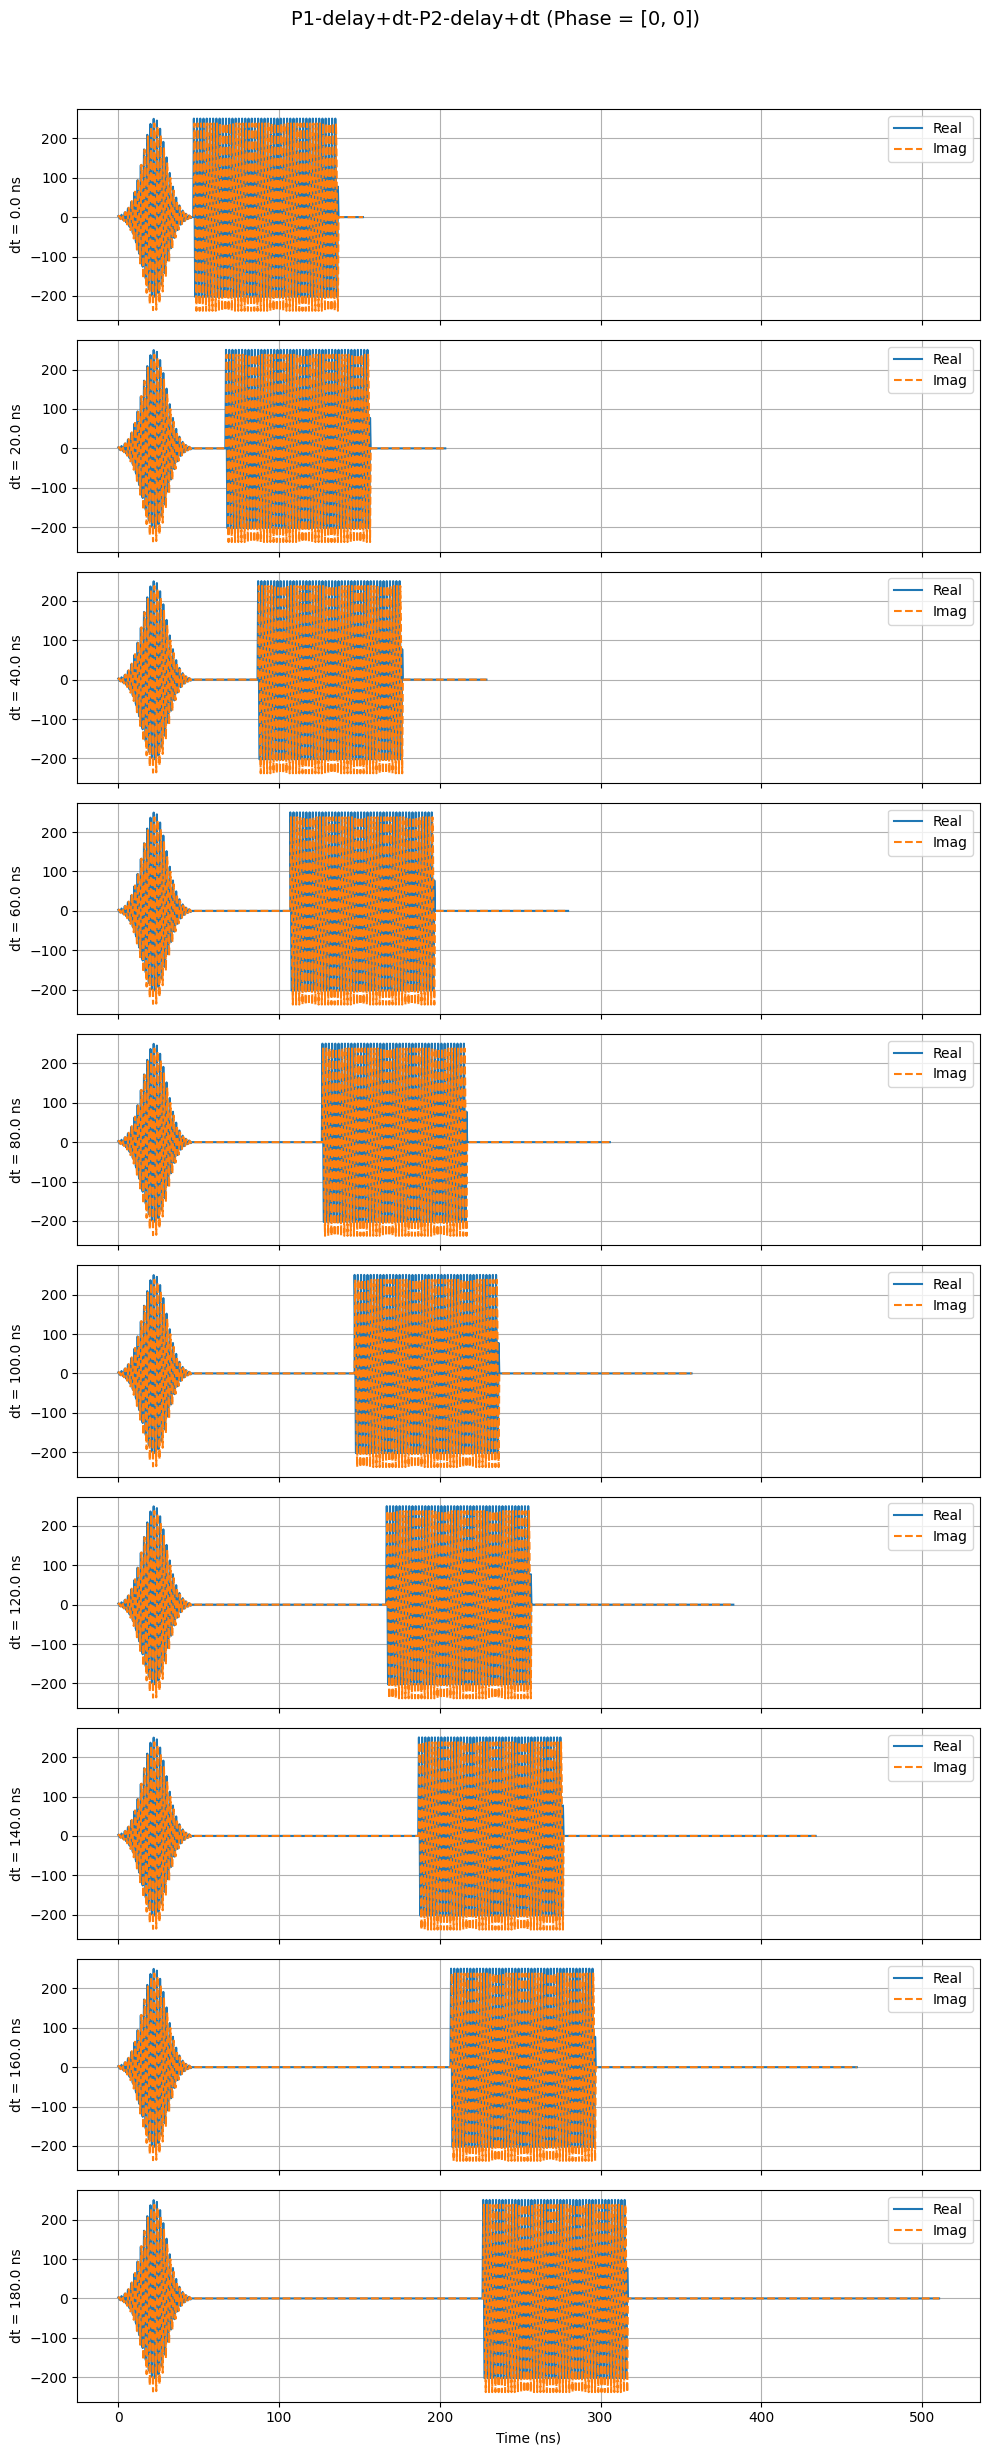

In [15]:
%matplotlib inline
dt_list_sample = dt_list[::10]  # Sample every 10th dt for plotting
fig, axs = plt.subplots(len(dt_list_sample), 1, figsize=(10, 2.5 * len(dt_list_sample)), sharex=True)
for i, dt in enumerate(dt_list_sample):
    (t, y, m) = next((v for (k, v) in segments if k[0] == dt and k[1] == [0, 0]))
    axs[i].plot(t * 1e9, np.real(y), label='Real')
    axs[i].plot(t * 1e9, np.imag(y), label='Imag', linestyle='--')
    axs[i].set_ylabel(f'dt = {dt*1e9:.1f} ns')
    axs[i].legend()
    axs[i].grid(True)
axs[-1].set_xlabel('Time (ns)')
plt.suptitle('P1-delay+dt-P2-delay+dt (Phase = [0, 0])', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Load the T2 sequences into the AWT

In [ ]:
# Load segments to the AWT

# Initialize the instrument
import os
import sys
srcpath = os.path.realpath('SourceFiles')
sys.path.append(srcpath)
from tevisainst import TEVisaInst
import numpy as np

#Set rates for DAC
sampleRateDAC = 2.5E9
#wavefore parameters
max_dac=(2**16)-1 # Max Dac
half_dac=max_dac/2 # DC Level
min_dac = 0
data_type = np.uint16 # DAC data type

# Connect to instrument(LAN)
inst_addr = '169.254.18.140' #Proteus Lan
inst = TEVisaInst(inst_addr)
resp = inst.send_scpi_query("*IDN?")
print('Connected to: ' + resp) # print insturmrnt ID
resp = inst.send_scpi_query("*OPT?")
print('Options: ' + resp) # print insturmrnt ID
# initialize DAC
inst.send_scpi_cmd('*CLS; *RST')

# I dont understand why this is needed

cmd = ':FREQ:RAST {0}'.format(sampleRateDAC)

inst.send_scpi_cmd(cmd)

inst.send_scpi_cmd(':INIT:CONT ON')

inst.send_scpi_cmd(':TRAC:DEL:ALL')



In [ ]:


for i, ((dt, phase), (t, y, m)) in enumerate(segments):
    ichan = 0
    ch = 1 # Output channel
    segnum = i
    wav = y
    mrk = m 
    seglen = len(wav)

    # Select channel
    cmd = ':INST:CHAN {0}'.format(ch)
    inst.send_scpi_cmd(cmd)

    # Define segment
    cmd = ':TRAC:DEF {0}, {1}'.format(segnum, seglen)
    inst.send_scpi_cmd(cmd)

    # Select the segment
    cmd = ':TRAC:SEL {0}'.format(segnum)
    inst.send_scpi_cmd(cmd)

    # increase the timeout before sending binary data
    inst.timeout = 30000

    # Send the binary-data:
    inst.write_binary_data('*OPC?; :TRAC:DATA', wav)
    # set normal timeout
    inst.timeout = 10000

    # Read if there is an error
    resp = inst.send_scpi_query(':SYST:ERR?')
    resp = resp.rstrip()
    if not resp.startswith('0'):
        print('ERROR: "{0}" after writing binary values'.format(resp))

    print('Downloaded waveform to segment {0} of channel {1}'.format(segnum, ch))


    # load markers
    markerNum = 1
    inst.timeout = 30000
    inst.write_binary_data('*OPC?; :MARK:DATA', mrk)
    inst.timeout = 10000
    # Read if there is an error
    resp = inst.send_scpi_query(':SYST:ERR?')
    resp = resp.rstrip()
    if not resp.startswith('0'):
        print('ERROR: "{0}" after writing binary values'.format(resp))

    print('Downloaded marker to segment {0} of channel {1}'.format(segnum, ch))
    
    # Select the marker to assign to above trace
    cmd = ':MARK:SEL {0}'.format(markerNum)
    inst.send_scpi_cmd(cmd)

    cmd = ':MARK:STAT ON'
    inst.send_scpi_cmd(cmd)

    
    resp = inst.send_scpi_query(':SYST:ERR?')
    print("Marker Error = ")
    print(resp)

    cmd = ':FUNC:MODE:SEGM {0}'.format(segnum)
    inst.send_scpi_cmd(cmd)

    # I dont understand these comments 
    cmd = ':VOLT MAX'
    rc = inst.send_scpi_cmd(cmd)

    cmd = ':VOLT:OFFS 0'
    rc = inst.send_scpi_cmd(cmd)

    cmd = ':OUTP ON'
    rc = inst.send_scpi_cmd(cmd)

    resp = inst.send_scpi_query(':SYST:ERR?')

    print("End of CH1, Gen Error = ")

    print(resp)

resp = inst.send_scpi_query(':SYST:ERR?')
print (resp)
print ("downloaded {} segments".format(len(segments)))

In [ ]:
# Load task table 
tasklen = len(segments)

channb= 1 
#Select channel
cmd = ':INST:CHAN {0}'.format(channb)
inst.send_scpi_cmd(cmd)

# set task table length 
cmd = ':TASK:COMP:LENG {0}'.format(tasklen)
inst.send_scpi_cmd(cmd)

for jj in range(tasklen):
    curr_task = jj+1
    loop = jj+1
    segnb = jj+1
    cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
    inst.send_scpi_cmd(cmd)
    
    cmd = ':TASK:COMP:TYPE SING'
    inst.send_scpi_cmd(cmd)
    
    cmd = ':TASK:COMP:LOOP {0}'.format(loop)
    inst.send_scpi_cmd(cmd)
    
    cmd = ':TASK:COMP:SEGM {0}'.format(segnb)
    inst.send_scpi_cmd(cmd)
    
    if curr_task==tasklen:
        cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
        inst.send_scpi_cmd(cmd)
    else:
        cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
        inst.send_scpi_cmd(cmd)

cmd = ':TASK:COMP:WRIT'
inst.send_scpi_cmd(cmd)
print('Downloading Task table of channel {0}'.format(channb))

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

 

In [ ]:
# Switch to the task mode and turn on channel and markers outputs
channb=1

cmd = ':INST:CHAN {0}'.format(channb)
inst.send_scpi_cmd(cmd)

cmd = ':OUTP ON'
inst.send_scpi_cmd(cmd)

cmd = 'FUNC:MODE TASK'
inst.send_scpi_cmd(cmd)

        
for jj in range(4):

    m = jj+1

    cmd = ':MARK:SEL {0}'.format(m)
    inst.send_scpi_cmd(cmd)

    cmd = ':MARK ON'
    inst.send_scpi_cmd(cmd) 
    


ValueError: too many values to unpack (expected 2)

# New section

# Loading the experiment text file and generate segments


In [ ]:
#!/usr/bin/env python3
import re
import numpy as np
from striprtf.striprtf import rtf_to_text

# Import your EPR_pulse class (with pulse_sequence implemented)
from pulse_sequence import EPR_pulse

class ExperimentParser:
    def __init__(self, filepath):
        self.filepath     = filepath
        self.phase_cycles = {}   # dict: 'ph0'→list, 'ph1'→list, etc.
        self.list1        = []   # list of dt values (ns)
        self.events       = {}   # ordered dict: segment_name → [lines]
        self._parse_file()

    def _parse_file(self):
        # 1) Read RTF and strip to plain text
        with open(self.filepath, 'r', encoding='latin-1') as f:
            rtf = f.read()
        plain = rtf_to_text(rtf)

        # 2) Split into non-empty, stripped lines
        lines = [ln.strip() for ln in plain.splitlines() if ln.strip()]

        # 3) Parse Phase cycles: ph0, ph1, ph2, ph3
        for ln in lines:
            m0 = re.match(r'(Ph0|ph0)\s*=\s*(.*)', ln)
            if m0:
                # e.g. "Ph0 = 0 90"
                nums = re.findall(r'\d+', m0.group(2))
                self.phase_cycles['ph0'] = [int(x) for x in nums]
            for ph in ('ph1','ph2','ph3'):
                if ln.lower().startswith(ph):
                    nums = re.findall(r'\d+', ln)
                    self.phase_cycles[ph] = [int(x) for x in nums]

        # 4) Extend ph0 to match the longest
        max_len = max(len(v) for v in self.phase_cycles.values())
        for k,v in self.phase_cycles.items():
            if len(v) < max_len:
                # repeat entries cyclically
                self.phase_cycles[k] = [v[i % len(v)] for i in range(max_len)]

        # 5) Parse List1 = start:step:end (all in ns)
        for ln in lines:
            m = re.match(r'List1\s*=\s*(\d+):(\d+):(\d+)', ln)
            if m:
                start, step, end = map(int, m.groups())
                # store as seconds for pulse_sequence
                self.list1 = [x * 1e-9 for x in range(start, end+1, step)]
                break

        # 6) Parse any number of segment blocks, in order
        current = None
        for ln in lines:
            b = re.match(r'\\begin\{(segment\d+)\}', ln)
            if b:
                current = b.group(1)
                self.events[current] = []
                continue
            if current and re.match(rf'\\end\{{{current}\}}', ln):
                current = None
                continue
            if current:
                # collect every line inside the block
                self.events[current].append(ln)

    def parse_event_line(self, ln):
        """
        Parse one line inside a segment block and return a dict:
          - type: 'delay', 'delay_list1', 'Square', or 'Gaussian'
          - length: seconds (for pulses and fixed delays)
          - amplitude: float (for pulses)
          - phase_key: 'ph0', 'ph1', etc. (for pulses)
        """
        ln = ln.strip()
        # 1) delay(list1) or dt(list1)
        if re.match(r'^(delay|dt)\s*\(\s*list1\s*\)$', ln, re.IGNORECASE):
            return {'type':'delay_list1'}

        # 2) delay(100)
        m = re.match(r'^(delay|dt)\s*\(\s*(\d+)\s*\)$', ln, re.IGNORECASE)
        if m:
            length_ns = int(m.group(2))
            return {'type':'delay', 'length': length_ns * 1e-9}

        # 3) Square(L,A,phase) pulses
        m = re.match(r'^Square\s*\(\s*(\d+)\s*,\s*([\d\.]+)\s*,\s*(ph\d)\s*\)$', ln)
        if m:
            length_ns = int(m.group(1))
            amp       = float(m.group(2))
            pk        = m.group(3).lower()
            return {
                'type':      'Square',
                'length':    length_ns * 1e-9,
                'amplitude': amp,
                'phase_key': pk
            }

        # 4) acquisition (Gaussian)(L,A,phase)
        m = re.match(r'^acquisition\s*\(Gaussian\)\s*\(\s*(\d+)\s*,\s*([\d\.]+)\s*,\s*(ph\d)\s*\)$', ln)
        if m:
            length_ns = int(m.group(1))
            amp       = float(m.group(2))
            pk        = m.group(3).lower()
            return {
                'type':      'Gaussian',
                'length':    length_ns * 1e-9,
                'amplitude': amp,
                'phase_key': pk
            }

        raise ValueError(f"Cannot parse event line: {ln}")

def generate_segments(parser, pulse_gen):
    """
    For every dt in parser.list1 and every phase‐cycle index,
    for every segment block in parser.events (in file order),
    build the exact (t, y) using pulse_gen.pulse_sequence().
    Returns a list of (dt, cycle_idx, segment_name, t, y).
    """
    segments_out = []
    # number of cycles = length of the (now-balanced) phase lists
    n_cycles = len(next(iter(parser.phase_cycles.values())))

    for dt in parser.list1:
        for idx in range(n_cycles):
            for seg_name, lines in parser.events.items():
                steps = []
                for ln in lines:
                    ev = parser.parse_event_line(ln)
                    if ev['type'] == 'delay_list1':
                        # use current dt
                        pts = int(round(dt * pulse_gen.sampling_rate))
                        steps.append(('delay', dt, {'points': pts}))
                    elif ev['type'] == 'delay':
                        pts = int(round(ev['length'] * pulse_gen.sampling_rate))
                        steps.append(('delay', ev['length'], {'points': pts}))
                    else:
                        # a pulse: pick the correct phase for this cycle
                        phase_list = parser.phase_cycles[ev['phase_key']]
                        phase = phase_list[idx]
                        params = {
                            'amplitude': ev['amplitude'],
                            'phase':     phase
                        }
                        steps.append((ev['type'], ev['length'], params))

                # now generate the waveform
                t_seq, y_seq = pulse_gen.pulse_sequence(steps)
                segments_out.append((dt, idx, seg_name, t_seq, y_seq))

    return segments_out

# ------------------------------
# Example usage:
# ------------------------------
if __name__ == '__main__':
    parser = ExperimentParser('/Users/HoangLe/Downloads/experiment.rtf')
    pulse  = EPR_pulse(sampling_rate=2.5e9, Vpp=500)

    segments = generate_segments(parser, pulse)
    print(f"Generated {len(segments)} segments:")
    for dt, idx, name, t, y in segments[:8]:
        print(f"  dt={dt*1e9:.0f} ns, cycle={idx}, block={name}, samples={len(t)}")

    # (You can now pack, upload, plot, etc.)

In [ ]:
!pip install striprtf

# Download segments to the AWT


In [ ]:
# Download segments

# data-type code: 'B' = uint8, 'H' = uint16
if dac_mode == 16:
    wav_dat_type = 'H'
else:
    wav_dat_type = 'B'
#wav_dat_type = 'H' if dac_mode == 16 else 'B'
mrk_dat_type = 'B'

ddr = num_channels if dac_mode == 8 else (num_channels/2)
print(ddr)



NumofSegments = len(segments)

for jj in range(int(ddr)):
    channb = jj+1
    for ii in range(NumofSegments):

        segnum = 1 + ii
        wav = segments[ii]
        mrk = marks[ii]
        print('Download wave to segment {0} of channel {1}'.format(segnum, channb))

        # Select channel
        cmd = ':INST:CHAN {0}'.format(channb)
        inst.send_scpi_cmd(cmd)

        # Define segment
        cmd = ':TRAC:DEF {0}, {1}'.format(segnum, seglen)
        inst.send_scpi_cmd(cmd) 
        
        # Select the segment
        cmd = ':TRAC:SEL {0}'.format(segnum)
        inst.send_scpi_cmd(cmd)
        
        # Increase the timeout before writing binary-data:
        inst.timeout = 30000

        # Send the binary-data with *OPC? added to the beginning of its prefix.
       # inst.write_binary_data('*OPC?; :TRAC:DATA', wav, datatype=wav_dat_type)
        cmd = ':TRAC:DATA {0}'.format(offset * offset_factor)
        inst.write_binary_data(cmd, wav)
        

        # Read the response to the *OPC? query that was added to the prefix of the binary data
        #resp = inst.read()

        # Set normal timeout
        inst.timeout = 10000;

        resp = inst.send_scpi_query(':SYST:ERR?')
        resp = resp.rstrip()
        if not resp.startswith('0'):
            print('ERROR: "{0}" after writing binary values'.format(resp))

        print('Download markers to segment {0} of channel {1}'.format(segnum, channb))

        # Increase the timeout before writing binary-data:
        inst.timeout = 30000

        # Send the binary-data with *OPC? added to the beginning of its prefix.
        #inst.write_binary_data('*OPC?; :MARK:DATA', mrk, datatype=mrk_dat_type)
        cmd = '*OPC?; :MARK:DATA'
        inst.write_binary_data(cmd, mrk)
        

        #Read the response to the *OPC? query that was added to the prefix of the binary data
        #resp = inst.read()

        # Set normal timeout
        inst.timeout = 10000

        resp = inst.send_scpi_query(':SYST:ERR?')
        resp = resp.rstrip()
        if not resp.startswith('0'):
            print('ERROR: "{0}" after writing binary values'.format(resp))


        # Play the specified segment at the selected channel:
        cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(segnum)
        inst.send_scpi_cmd(cmd)    

        # Turn on the output of the selected channel:
        #cmd = ':OUTP ON'
        #pyte.send_cmd(inst, cmd, paranoia_level) 

        resp = inst.send_scpi_query(':SYST:ERR?')
        print(resp)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

del waves
del wav


        

# Testing the YAML config for the experiment

In [ ]:
!pip install PyYAML

In [23]:
#!/usr/bin/env python3
"""
run_experiment.py

Reads a YAML experiment file, validates and tiles phase cycles of varying lengths,
accepts both explicit lists and range syntax for delays, then generates all waveform
segments via an EPR_pulse instance.
"""
import sys
import yaml
import re
import numpy as np
from pulse_sequence import EPR_pulse


def parse_list1(list1_cfg):
    """
    Accept either a YAML list of numbers or a string "start:step:end" to define delays.
    Returns a list of floats in seconds.
    """
    if isinstance(list1_cfg, str):
        # Expect format "start:step:end" in ns
        m = re.match(r"^(\d+):(\d+):(\d+)$", list1_cfg)
        if not m:
            raise ValueError(f"Invalid list1 range syntax: {list1_cfg}")
        start, step, end = map(int, m.groups())
        return [x * 1e-9 for x in range(start, end + 1, step)]
    elif isinstance(list1_cfg, list):
        # Explicit list, assume values in ns or numeric
        vals = []
        for x in list1_cfg:
            if isinstance(x, (int, float)):
                vals.append(x * 1e-9)
            else:
                raise ValueError(f"Invalid list1 element: {x}")
        return vals
    else:
        raise ValueError(f"Unsupported list1 type: {type(list1_cfg)}")


def load_and_validate_config(path):
    """
    Load and validate the experiment configuration from YAML.
    - Ensures version == 1.0
    - Tiles shorter phase cycle lists to match the longest
    - Parses list1 as explicit list or range string
    """
    with open(path, 'r') as f:
        cfg = yaml.safe_load(f)

    # Version check
    if cfg.get('version') != 1.0:
        raise ValueError(f"Unsupported config version: {cfg.get('version')}")

    # Tile phase_cycles
    ph = cfg.get('phase_cycles')
    if not isinstance(ph, dict) or not ph:
        raise ValueError("'phase_cycles' section is required and must be a map in config")
    max_len = max(len(v) for v in ph.values())
    for k, v in ph.items():
        if len(v) < max_len:
            ph[k] = [v[i % len(v)] for i in range(max_len)]
    cfg['phase_cycles'] = ph

    # Parse list1 (ns) to seconds
    if 'list1' not in cfg:
        raise ValueError("'list1' section is required in config")
    cfg['list1'] = parse_list1(cfg['list1'])

    # Validate segments
    segs = cfg.get('segments')
    if not isinstance(segs, list) or not segs:
        raise ValueError("'segments' must be a non-empty list of segment definitions")
    for seg in segs:
        if 'name' not in seg:
            raise ValueError("Each segment must have a 'name'")
        steps = seg.get('steps')
        if not isinstance(steps, list) or not steps:
            raise ValueError(f"Segment {seg['name']} must have a non-empty 'steps' list")
        for step in steps:
            if 'type' not in step or 'length' not in step:
                raise ValueError(f"Each step in {seg['name']} must have 'type' and 'length'")
            tp = step['type']
            if tp not in ('Gaussian', 'Square', 'delay'):
                raise ValueError(f"Unknown step type '{tp}' in segment {seg['name']}")
            ln = step['length']
            if not (isinstance(ln, (int, float)) or (isinstance(ln, str) and ln == 'list1')):
                raise ValueError(f"Invalid length '{ln}' in segment {seg['name']}")
            if tp in ('Gaussian', 'Square'):
                if 'amplitude' not in step or 'phase' not in step:
                    raise ValueError(f"Pulse step in {seg['name']} must have 'amplitude' and 'phase'")

    return cfg


def generate_all_segments(cfg, pulse_gen):
    """
    For every dt in cfg['list1'] and every phase-cycle index,
    for every segment in cfg['segments'], build the exact (t, y).
    Returns: list of tuples (dt, cycle_idx, segment_name, t, y)
    """
    segments_out = []
    n_cycles = len(next(iter(cfg['phase_cycles'].values())))

    for dt in cfg['list1']:
        for idx in range(n_cycles):
            for seg in cfg['segments']:
                steps = []
                for step in seg['steps']:
                    tp = step['type']
                    # resolve length
                    if step['length'] == 'list1':
                        length = dt
                    else:
                        length = step['length'] * 1e-9
                    if tp == 'delay':
                        pts = int(round(length * pulse_gen.sampling_rate))
                        steps.append(('delay', length, {'points': pts}))
                    else:
                        amp = step['amplitude']
                        ph_key = step['phase']
                        phase = cfg['phase_cycles'][ph_key][idx]
                        steps.append((tp, length, {'amplitude': amp, 'phase': phase}))
                t_seq, y_seq = pulse_gen.pulse_sequence(steps)
                segments_out.append((dt, idx, seg['name'], t_seq, y_seq))

    return segments_out


if __name__ == '__main__':
    if len(sys.argv) != 2:
        print("Usage: run_experiment.py <experiment.yaml>")
        sys.exit(1)

    # Instead of using sys.argv in a notebook, just hard-code or parameterize:
    cfg_path = "experiment.yaml"   # or wherever your file lives
    cfg      = load_and_validate_config(cfg_path)

    pulse    = EPR_pulse(sampling_rate=2.5e9, Vpp=500)
    # Now `cfg` is your validated config dict and you can proceed:
    segments = generate_all_segments(cfg, pulse)

    print(f"Generated {len(segments)} segments:")
    for dt, idx, name, t, y in segments[:24]:
        print(f"  dt={dt*1e9:.0f} ns, cycle={idx}, segment={name}, samples={len(t)}")


Generated 120 segments:
  dt=100 ns, cycle=0, segment=segment1, samples=64
  dt=100 ns, cycle=0, segment=segment2, samples=256
  dt=100 ns, cycle=0, segment=segment3, samples=320
  dt=100 ns, cycle=1, segment=segment1, samples=64
  dt=100 ns, cycle=1, segment=segment2, samples=256
  dt=100 ns, cycle=1, segment=segment3, samples=320
  dt=100 ns, cycle=2, segment=segment1, samples=64
  dt=100 ns, cycle=2, segment=segment2, samples=256
  dt=100 ns, cycle=2, segment=segment3, samples=320
  dt=100 ns, cycle=3, segment=segment1, samples=64
  dt=100 ns, cycle=3, segment=segment2, samples=256
  dt=100 ns, cycle=3, segment=segment3, samples=320
  dt=200 ns, cycle=0, segment=segment1, samples=64
  dt=200 ns, cycle=0, segment=segment2, samples=512
  dt=200 ns, cycle=0, segment=segment3, samples=320
  dt=200 ns, cycle=1, segment=segment1, samples=64
  dt=200 ns, cycle=1, segment=segment2, samples=512
  dt=200 ns, cycle=1, segment=segment3, samples=320
  dt=200 ns, cycle=2, segment=segment1, sample

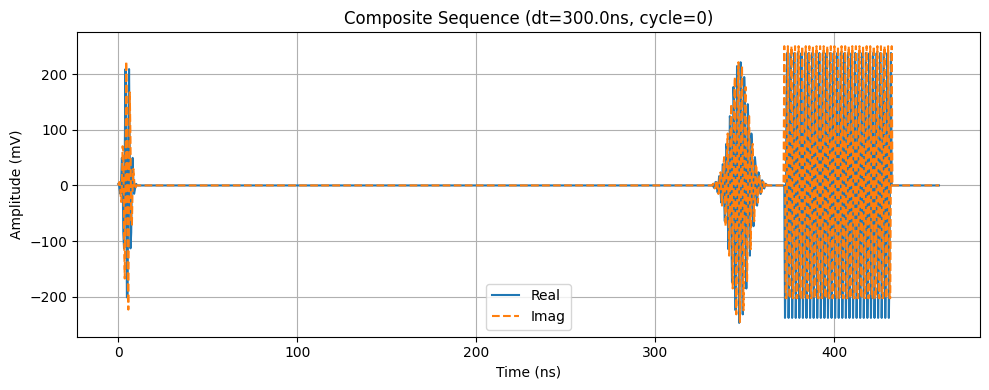

In [25]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# 1) Assume you’ve already done:
#    cfg  = load_and_validate_config('experiment.yaml')
#    pulse = EPR_pulse(sampling_rate=2.5e9, Vpp=500)
#    segments = generate_all_segments(cfg, pulse)

# 2) Pick the first dt and first cycle
dt0     = cfg['list1'][2]
cycle0  = 0

# 3) Extract only segment1, segment2, segment3 for that dt & cycle
#    segments is a list of (dt, idx, name, t, y)
sel = [seg for seg in segments
       if np.isclose(seg[0], dt0) and seg[1] == cycle0 and seg[2] in ('segment1','segment2','segment3')]

# 4) Order them by the order in cfg['segments']
order = [s['name'] for s in cfg['segments']]
sel.sort(key=lambda seg: order.index(seg[2]))

# 5) Stitch them end‐to‐end
t_comb = np.array([], dtype=float)
y_comb = np.array([], dtype=complex)
offset = 0.0
for dt, idx, name, t, y in sel:
    # duration of this block
    dur = t[-1] - t[0]
    # shift its time so it starts where the last one ended
    t_shifted = t + offset
    t_comb = np.concatenate([t_comb, t_shifted])
    y_comb = np.concatenate([y_comb, y])
    offset += dur

# 6) Plot real & imaginary
plt.figure(figsize=(10,4))
plt.plot(t_comb*1e9, np.real(y_comb), label='Real', lw=1.5)
plt.plot(t_comb*1e9, np.imag(y_comb), '--', label='Imag', lw=1.5)
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (mV)')
plt.title(f'Composite Sequence (dt={dt0*1e9:.1f}ns, cycle={cycle0})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()